# Improved Baseline Model

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Setup

In [55]:
'Gender', 'Age', 'Race_Ethnicity', 'Household_Size','Poverty_Income_Ratio','Poor_Appetite_Overeating', 'Feeling_Depressed', 'Work_Status', 'Avg_Exercise_Per_Day', 'Avg_Sleep'

('Gender',
 'Age',
 'Race_Ethnicity',
 'Household_Size',
 'Poverty_Income_Ratio',
 'Poor_Appetite_Overeating',
 'Feeling_Depressed',
 'Work_Status',
 'Avg_Exercise_Per_Day',
 'Avg_Sleep')

In [56]:
df = pd.read_csv('data/data.csv')

feature_cols = [
    'Gender', 'Age', 'Race_Ethnicity', 'Household_Size', 'Poverty_Income_Ratio',
    'Poor_Appetite_Overeating', 'Feeling_Depressed', 'Work_Status', 'Avg_Exercise_Per_Day'
]
target_col = 'Avg_Sleep'

X = df[feature_cols].copy()
y = df[target_col].copy()

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("Unknown")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(X[col].median())

# Encoders
# Ordinal: Order matters for mental health questions
ordinal_feats = ['Poor_Appetite_Overeating', 'Feeling_Depressed']
ordinal_order = [['Not at all', 'Several days', 'More than half the days', 'Nearly every day']] * 2

# Nominal: No order (Gender, Race, Work)
nominal_feats = ['Gender', 'Race_Ethnicity', 'Work_Status']

# Numeric: Scale these
numeric_feats = ['Age', 'Household_Size', 'Poverty_Income_Ratio']

### Building the Transformer

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feats),
        ('ord', OrdinalEncoder(categories=ordinal_order, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_feats),
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_feats)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

### Models

In [58]:
models = {
    # --- Linear Models ---
    "Ridge (L2 Penalty)": Ridge(alpha=1.0),
    "Lasso (L1 Penalty)": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    
    # --- Support Vector Machines ---
    "SVR (RBF Kernel)": SVR(C=1.0, epsilon=0.1),
    
    # --- Nearest Neighbors ---
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    
    # --- Tree Ensembles ---
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=36),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=36),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=36),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=36),
    
    # --- Neural Networks ---
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=36)
}

### Training the Models

In [59]:
results = []

print(f"{'Model':<30} | {'MAE':<10} | {'MSE':<10} | {'R2 Score':<10}")
print("-" * 70)

for name, model in models.items():
    # Build Pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Train
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'MSE': mse, 'R2': r2})
    print(f"{name:<30} | {mae:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

Model                          | MAE        | MSE        | R2 Score  
----------------------------------------------------------------------
Ridge (L2 Penalty)             | 1.0614     | 2.1069     | 0.0239    
Lasso (L1 Penalty)             | 1.0569     | 2.1019     | 0.0263    
ElasticNet                     | 1.0576     | 2.1001     | 0.0271    
SVR (RBF Kernel)               | 1.0751     | 2.1677     | -0.0042   
K-Nearest Neighbors            | 1.1062     | 2.2974     | -0.0643   
Random Forest                  | 1.0590     | 2.1207     | 0.0176    
Extra Trees                    | 1.0713     | 2.1679     | -0.0043   
Gradient Boosting              | 1.0631     | 2.1197     | 0.0180    
Hist Gradient Boosting         | 1.0840     | 2.1880     | -0.0136   
Neural Network (MLP)           | 1.2038     | 2.7360     | -0.2675   


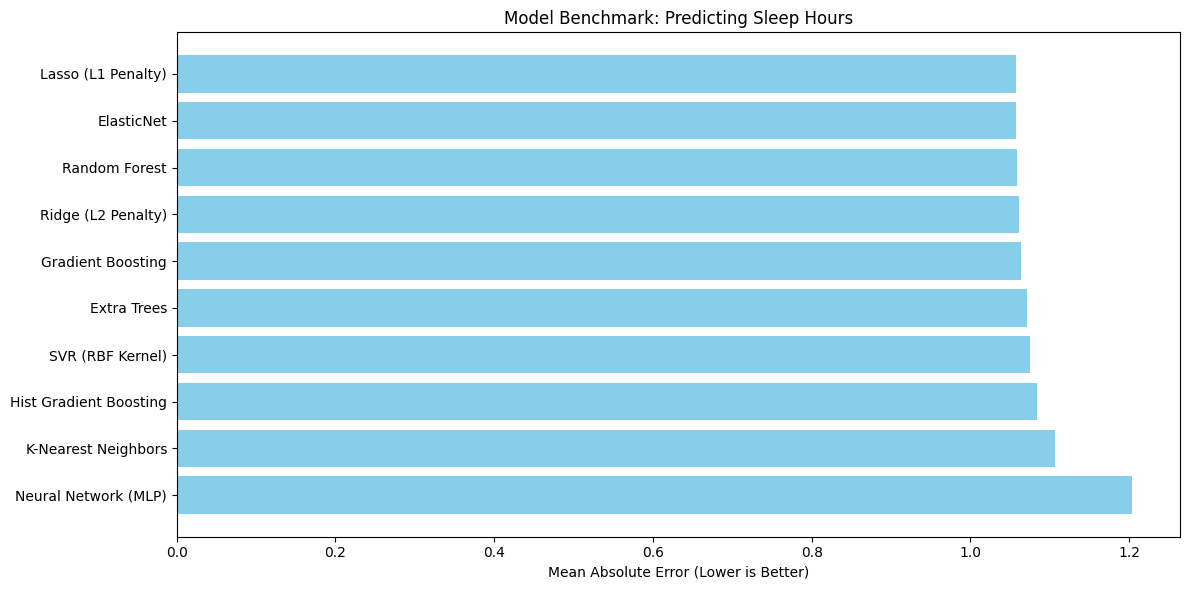

In [26]:
results_df = pd.DataFrame(results).sort_values(by='MAE', ascending=True)

plt.figure(figsize=(12, 6))
bars = plt.barh(results_df['Model'], results_df['MAE'], color='skyblue')
plt.xlabel('Mean Absolute Error (Lower is Better)')
plt.title('Model Benchmark: Predicting Sleep Hours')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('model_benchmark.png')

### Testing Neural Networks

Grid search progress:  23%|██▎       | 30/128 [01:51<06:41,  4.09s/combo]/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Grid search progress: 100%|██████████| 128/128 [1:42:43<00:00, 48.15s/combo]  


Starting Neural Network Hyperparameter Tuning :) :) :(


Grid search progress:   0%|          | 0/128 [00:00<?, ?combo/s]/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/mo


Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
Best CV MAE Score: 1.0851
------------------------------
Final Test MAE: 1.0669
Final Test R2:  0.0171


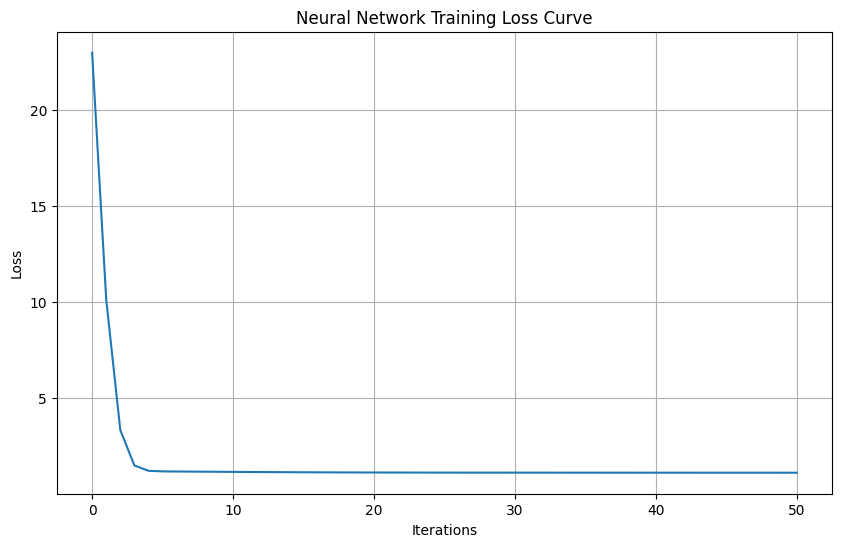

In [27]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from tqdm.auto import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(X_train, y_train)

class TQDMGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        all_params = list(ParameterGrid(self.param_grid))
        chunk_size = 5 

        with tqdm(total=len(all_params),
                  desc="Grid search progress",
                  unit="combo") as pbar:
            for start in range(0, len(all_params), chunk_size):
                chunk = all_params[start:start + chunk_size]
                evaluate_candidates(chunk)
                pbar.update(len(chunk))


mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(
        max_iter=2000,
        random_state=36,
        early_stopping=True
    ))
])

param_grid = {
    'mlp__hidden_layer_sizes': [
        (50,),
        (100,),
        (64, 32),
        (100, 50, 25)
    ],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate_init': [0.001, 0.01]
}


print("Starting Neural Network Hyperparameter Tuning :) :) :(")

grid_search = TQDMGridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=5,                               
    scoring='neg_mean_absolute_error',  
    n_jobs=-1,                          
    verbose=0                           
)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV MAE Score: {-grid_search.best_score_:.4f}")

best_nn = grid_search.best_estimator_
y_pred = best_nn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test R2:  {r2:.4f}")

if best_nn.named_steps['mlp'].solver != 'lbfgs':
    plt.figure(figsize=(10, 6))
    plt.plot(best_nn.named_steps['mlp'].loss_curve_)
    plt.title("Neural Network Training Loss Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# Load & basic preprocessing
# =========================
df = pd.read_csv('data/data.csv')

feature_cols = [
    'Gender', 'Age', 'Race_Ethnicity', 'Household_Size', 'Poverty_Income_Ratio',
    'Poor_Appetite_Overeating', 'Feeling_Depressed', 'Work_Status', 'Avg_Exercise_Per_Day'
]
target_col = 'Avg_Sleep'

X = df[feature_cols].copy()
y = df[target_col].copy()

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("Unknown")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(X[col].median())

# =========================
# Column types & encoders
# =========================
ordinal_feats = ['Poor_Appetite_Overeating', 'Feeling_Depressed']
ordinal_order = [['Not at all', 'Several days', 'More than half the days', 'Nearly every day']] * 2

nominal_feats = ['Gender', 'Race_Ethnicity', 'Work_Status']

numeric_feats = ['Age', 'Household_Size', 'Poverty_Income_Ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feats),
        ('ord', OrdinalEncoder(categories=ordinal_order,
                               handle_unknown='use_encoded_value',
                               unknown_value=-1),
         ordinal_feats),
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_feats)
    ])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=36
)

# =========================
# Base Models
# =========================
models = {
    "Ridge (L2 Penalty)": Ridge(alpha=1.0),
    "Lasso (L1 Penalty)": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "SVR (RBF Kernel)": SVR(C=1.0, epsilon=0.1),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=36),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=36),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=36),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=36),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=36)
}

# =========================
# Parameter grids for grid search
# =========================
param_grids = {
    "Lasso (L1 Penalty)": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__max_iter": [1000, 5000, 10000],
        "model__tol": [1e-4, 1e-3]
    },
    "ElasticNet": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [1000, 5000, 10000],
        "model__tol": [1e-4, 1e-3]
    },
    "Random Forest": {
        "model__n_estimators": [100, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", 0.5]
    }
}

results = []

print(f"{'Model':<30} | {'MAE':<10} | {'MSE':<10} | {'R2 Score':<10}")
print("-" * 70)

for name, base_model in models.items():
    # Build pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', base_model)])

    # If this model has a param grid, do a GridSearchCV
    if name in param_grids:
        print(f"\nRunning GridSearchCV for: {name}")
        grid = GridSearchCV(
            pipe,
            param_grid=param_grids[name],
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best CV R2 for {name}: {grid.best_score_:.4f}")

        # Use the tuned model for test evaluation
        y_pred = best_model.predict(X_test)
        used_model = best_model
    else:
        # No grid search – just fit the pipeline as-is
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        used_model = pipe

    # Evaluate on test set
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    })

    print(f"{name:<30} | {mae:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

# Optionally: turn results into a DataFrame to inspect/sort
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\nSorted results by R2:")
print(results_df)


Model                          | MAE        | MSE        | R2 Score  
----------------------------------------------------------------------
Ridge (L2 Penalty)             | 1.0614     | 2.1069     | 0.0239    

Running GridSearchCV for: Lasso (L1 Penalty)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Lasso (L1 Penalty): {'model__alpha': 0.001, 'model__max_iter': 1000, 'model__tol': 0.0001}
Best CV R2 for Lasso (L1 Penalty): 0.0199
Lasso (L1 Penalty)             | 1.0605     | 2.1049     | 0.0249    

Running GridSearchCV for: ElasticNet
Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+02, tolerance: 9.066e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.599e+01, tolerance: 8.983e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Best params for ElasticNet: {'model__alpha': 0.01, 'model__l1_ratio': 0.1, 'model__max_iter': 1000, 'model__tol': 0.001}
Best CV R2 for ElasticNet: 0.0205
ElasticNet                     | 1.0598     | 2.1037     | 0.0254    
SVR (RBF Kernel)               | 1.0751     | 2.1677     | -0.0042   
K-Nearest Neighbors            | 1.1062     | 2.2974     | -0.0643   

Running GridSearchCV for: Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params for Random Forest: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best CV R2 for Random Forest: 0.0235
Random Forest                  | 1.0536     | 2.0893     | 0.0321    
Extra Trees                    | 1.0713     | 2.1679     | -0.0043   
Gradient Boosting              | 1.0631     | 2.1197     | 0.0180    
Hist Gradient Boosting         | 1.0840     | 2.1880     | -0.0136   
Neural Network (MLP)           | 1.2038     | 2.7360     | -0.2675   

Sorted results by R2:
                    Model       MAE       MSE        R2
5           Random Forest  1.053567  2.089299  0.032105
2              ElasticNet  1.059820  2.103710  0.025429
1      Lasso (L1 Penalty)  1.060502  2.104916  0.024870
0      Ridge (L2 Penalty)  1.061361  2.106902  0.023950
7       Gradient Boosting  1.063089  2.119689  0.018026
3        SVR (RBF Kernel)  1.075076  2.167657 -0.004195
6             Extra Tr

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor,
                              HistGradientBoostingRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# Load & basic preprocessing
# =========================
df = pd.read_csv('data/data.csv')

feature_cols = [
    'Gender', 'Age', 'Race_Ethnicity', 'Household_Size', 'Poverty_Income_Ratio',
    'Poor_Appetite_Overeating', 'Feeling_Depressed', 'Work_Status', 'Avg_Exercise_Per_Day'
]
target_col = 'Avg_Sleep'

X = df[feature_cols].copy()
y = df[target_col].copy()

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("Unknown")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(X[col].median())

# =========================
# Column types & encoders
# =========================
ordinal_feats = ['Poor_Appetite_Overeating', 'Feeling_Depressed']
ordinal_order = [['Not at all', 'Several days',
                  'More than half the days', 'Nearly every day']] * 2

nominal_feats = ['Gender', 'Race_Ethnicity', 'Work_Status']

numeric_feats = ['Age', 'Household_Size', 'Poverty_Income_Ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feats),
        ('ord', OrdinalEncoder(categories=ordinal_order,
                               handle_unknown='use_encoded_value',
                               unknown_value=-1),
         ordinal_feats),
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         nominal_feats)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=36
)

# =========================
# Models
# =========================
models = {
    "Ridge (L2 Penalty)": Ridge(),
    "Lasso (L1 Penalty)": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR (RBF Kernel)": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=36),
    "Extra Trees": ExtraTreesRegressor(random_state=36),
    "Gradient Boosting": GradientBoostingRegressor(random_state=36),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=36),
    "Neural Network (MLP)": MLPRegressor(max_iter=1000, random_state=36)
}

# =========================
# Hyperparameter grids
# =========================
param_grids = {
    "Ridge (L2 Penalty)": {
        "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "Lasso (L1 Penalty)": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__max_iter": [1000, 5000, 10000]
    },
    "ElasticNet": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [1000, 5000]
    },
    "SVR (RBF Kernel)": {
        "model__C": [0.1, 1, 10, 100],
        "model__epsilon": [0.01, 0.1, 0.5],
        "model__gamma": ["scale", "auto"]
    },
    "K-Nearest Neighbors": {
        "model__n_neighbors": [3, 5, 10, 20],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]  # Manhattan vs Euclidean
    },
    "Random Forest": {
        "model__n_estimators": [100, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", 0.5]
    },
    "Extra Trees": {
        "model__n_estimators": [100, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", 0.5]
    },
    "Gradient Boosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 4],
        "model__subsample": [0.8, 1.0]
    },
    "Hist Gradient Boosting": {
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [None, 5, 10],
        "model__max_leaf_nodes": [31, 63, 127],
        "model__min_samples_leaf": [20, 50, 100]
    },
    "Neural Network (MLP)": {
        "model__hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
        "model__activation": ["relu", "tanh"],
        "model__alpha": [1e-5, 1e-4, 1e-3],
        "model__learning_rate_init": [0.001, 0.01]
    }
}

# =========================
# Grid search
# =========================
results = []

print(f"{'Model':<30} | {'MAE':<10} | {'MSE':<10} | {'R2 Score':<10}")
print("-" * 70)

for name, model in models.items():
    print(f"\nTuning {name}...")
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring="r2",      
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Best R2": grid.best_score_,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

    print(f"Best params: {grid.best_params_}")
    print(f"Best CV R2: {grid.best_score_:.4f}")
    print(f"{name:<30} | {mae:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="R2", ascending=False)
print("\nSorted results by test R2:")
print(results_df_sorted[["Model", "R2", "MAE", "MSE"]])


Model                          | MAE        | MSE        | R2 Score  
----------------------------------------------------------------------

Tuning Ridge (L2 Penalty)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'model__alpha': 100.0}
Best CV R2: 0.0211
Ridge (L2 Penalty)             | 1.0598     | 2.1040     | 0.0253    

Tuning Lasso (L1 Penalty)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'model__alpha': 0.001, 'model__max_iter': 1000}
Best CV R2: 0.0199
Lasso (L1 Penalty)             | 1.0605     | 2.1049     | 0.0249    

Tuning ElasticNet...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+02, tolerance: 9.066e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.284e+01, tolerance: 9.173e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.1, 'model__max_iter': 1000}
Best CV R2: 0.0205
ElasticNet                     | 1.0598     | 2.1037     | 0.0254    

Tuning SVR (RBF Kernel)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'model__C': 0.1, 'model__epsilon': 0.01, 'model__gamma': 'auto'}
Best CV R2: 0.0263
SVR (RBF Kernel)               | 1.0509     | 2.0870     | 0.0332    

Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'model__n_neighbors': 20, 'model__p': 2, 'model__weights': 'uniform'}
Best CV R2: -0.0164
K-Nearest Neighbors            | 1.0912     | 2.2198     | -0.0284   

Tuning Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best CV R2: 0.0235
Random Forest                  | 1.0536     | 2.0893     | 0.0321    

Tuning Extra Trees...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best CV R2: 0.0207
Extra Trees                    | 1.0563     | 2.0959     | 0.0290    

Tuning Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV R2: 0.0239
Gradient Boosting              | 1.0480     | 2.0776     | 0.0375    

Tuning Hist Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__max_leaf_nodes': 31, 'model__min_samples_leaf': 50}
Best CV R2: 0.0230
Hist Gradient Boosting         | 1.0548     | 2.0962     | 0.0289    

Tuning Neural Network (MLP)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the opti

Best params: {'model__activation': 'tanh', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': (128, 64, 32), 'model__learning_rate_init': 0.01}
Best CV R2: -0.0037
Neural Network (MLP)           | 1.0663     | 2.1688     | -0.0047   

Sorted results by test R2:
                    Model        R2       MAE       MSE
7       Gradient Boosting  0.037534  1.048020  2.077580
3        SVR (RBF Kernel)  0.033151  1.050917  2.087041
5           Random Forest  0.032105  1.053567  2.089299
6             Extra Trees  0.029044  1.056324  2.095905
8  Hist Gradient Boosting  0.028888  1.054831  2.096244
2              ElasticNet  0.025428  1.059818  2.103711
0      Ridge (L2 Penalty)  0.025300  1.059821  2.103988
1      Lasso (L1 Penalty)  0.024870  1.060502  2.104916
9    Neural Network (MLP) -0.004722  1.066331  2.168794
4     K-Nearest Neighbors -0.028371  1.091160  2.219841


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor,
                              HistGradientBoostingRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================
# Load & basic preprocessing
# =========================
df = pd.read_csv('data/data.csv')

# ---- Only use selected features ----
feature_cols = [
    'Age',
    'Poverty_Income_Ratio',
    'Work_Status',
    'Avg_Exercise_Per_Day'
]
target_col = 'Avg_Sleep'

X = df[feature_cols].copy()
y = df[target_col].copy()

# Handle missing values
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("Unknown")
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(X[col].median())

# =========================
# Column types & encoders
# =========================
# No more ordinal features since we dropped the PHQ items
numeric_feats = ['Age', 'Poverty_Income_Ratio', 'Avg_Exercise_Per_Day']
nominal_feats = ['Work_Status']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feats),
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         nominal_feats)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=36
)

# =========================
# Models
# =========================
models = {
    "Ridge (L2 Penalty)": Ridge(),
    "Lasso (L1 Penalty)": Lasso(),
    "ElasticNet": ElasticNet(),
    "SVR (RBF Kernel)": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=36),
    "Extra Trees": ExtraTreesRegressor(random_state=36),
    "Gradient Boosting": GradientBoostingRegressor(random_state=36),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=36),
    "Neural Network (MLP)": MLPRegressor(max_iter=1000, random_state=36)
}

# =========================
# Hyperparameter grids
# (all use 'model__' prefix for pipeline)
# =========================
param_grids = {
    "Ridge (L2 Penalty)": {
        "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "Lasso (L1 Penalty)": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__max_iter": [1000, 5000, 10000]
    },
    "ElasticNet": {
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [1000, 5000]
    },
    "SVR (RBF Kernel)": {
        "model__C": [0.1, 1, 10, 100],
        "model__epsilon": [0.01, 0.1, 0.5],
        "model__gamma": ["scale", "auto"]
    },
    "K-Nearest Neighbors": {
        "model__n_neighbors": [3, 5, 10, 20],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]  # Manhattan vs Euclidean
    },
    "Random Forest": {
        "model__n_estimators": [100, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", 0.5]
    },
    "Extra Trees": {
        "model__n_estimators": [100, 300, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", "log2", 0.5]
    },
    "Gradient Boosting": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 4],
        "model__subsample": [0.8, 1.0]
    },
    "Hist Gradient Boosting": {
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [None, 5, 10],
        "model__max_leaf_nodes": [31, 63, 127],
        "model__min_samples_leaf": [20, 50, 100]
    },
    "Neural Network (MLP)": {
        "model__hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
        "model__activation": ["relu", "tanh"],
        "model__alpha": [1e-5, 1e-4, 1e-3],
        "model__learning_rate_init": [0.001, 0.01]
    }
}

# =========================
# Grid search over all models
# =========================
results = []

print(f"{'Model':<30} | {'MAE':<10} | {'MSE':<10} | {'R2 Score':<10}")
print("-" * 70)

for name, model in models.items():
    print(f"\nTuning {name}...")
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV Best R2": grid.best_score_,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

    print(f"Best params: {grid.best_params_}")
    print(f"Best CV R2: {grid.best_score_:.4f}")
    print(f"{name:<30} | {mae:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

# =========================
# Summarize results
# =========================
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="R2", ascending=False)
print("\nSorted results by test R2:")
print(results_df_sorted[["Model", "R2", "MAE", "MSE"]])


Model                          | MAE        | MSE        | R2 Score  
----------------------------------------------------------------------

Tuning Ridge (L2 Penalty)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'model__alpha': 100.0}
Best CV R2: 0.0167
Ridge (L2 Penalty)             | 1.0580     | 2.1117     | 0.0217    

Tuning Lasso (L1 Penalty)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'model__alpha': 0.01, 'model__max_iter': 1000}
Best CV R2: 0.0169
Lasso (L1 Penalty)             | 1.0577     | 2.1114     | 0.0219    

Tuning ElasticNet...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.007e+01, tolerance: 9.173e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.809e+01, tolerance: 9.066e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.7, 'model__max_iter': 1000}
Best CV R2: 0.0170
ElasticNet                     | 1.0577     | 2.1105     | 0.0223    

Tuning SVR (RBF Kernel)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'model__C': 0.1, 'model__epsilon': 0.01, 'model__gamma': 'auto'}
Best CV R2: 0.0228
SVR (RBF Kernel)               | 1.0497     | 2.1002     | 0.0270    

Tuning K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'model__n_neighbors': 20, 'model__p': 1, 'model__weights': 'uniform'}
Best CV R2: -0.0234
K-Nearest Neighbors            | 1.0779     | 2.1679     | -0.0043   

Tuning Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best CV R2: 0.0222
Random Forest                  | 1.0494     | 2.0839     | 0.0346    

Tuning Extra Trees...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'model__max_depth': 10, 'model__max_features': 0.5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best CV R2: 0.0227
Extra Trees                    | 1.0499     | 2.0925     | 0.0306    

Tuning Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best CV R2: 0.0222
Gradient Boosting              | 1.0513     | 2.0917     | 0.0310    

Tuning Hist Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__max_leaf_nodes': 31, 'model__min_samples_leaf': 100}
Best CV R2: 0.0202
Hist Gradient Boosting         | 1.0502     | 2.0858     | 0.0337    

Tuning Neural Network (MLP)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/sophiavo/CSE-158-Assignment-2/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'model__activation': 'relu', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': (128, 64), 'model__learning_rate_init': 0.001}
Best CV R2: 0.0177
Neural Network (MLP)           | 1.0536     | 2.0858     | 0.0337    

Sorted results by test R2:
                    Model        R2       MAE       MSE
5           Random Forest  0.034614  1.049375  2.083882
9    Neural Network (MLP)  0.033709  1.053628  2.085835
8  Hist Gradient Boosting  0.033703  1.050234  2.085849
7       Gradient Boosting  0.030995  1.051254  2.091694
6             Extra Trees  0.030625  1.049905  2.092493
3        SVR (RBF Kernel)  0.027038  1.049714  2.100237
2              ElasticNet  0.022305  1.057652  2.110453
1      Lasso (L1 Penalty)  0.021868  1.057696  2.111397
0      Ridge (L2 Penalty)  0.021744  1.058031  2.111665
4     K-Nearest Neighbors -0.004327  1.077874  2.167941
